> **Problem overview**

"Quick, Draw!" was released as an experimental game to educate the public in a playful way about how AI works. The game prompts users to draw an image depicting a certain category, such as ”banana,” “table,” etc. The game generated more than 1B drawings, of which a subset was publicly released as the basis for this competition’s training set. That subset contains 50M drawings encompassing 340 label categories.

Sounds fun, right? Here's the challenge: since the training data comes from the game itself, drawings can be incomplete or may not match the label. You’ll need to build a recognizer that can effectively learn from this noisy data and perform well on a manually-labeled test set from a different distribution.

Your task is to build a better classifier for the existing Quick, Draw! dataset. By advancing models on this dataset, Kagglers can improve pattern recognition solutions more broadly. This will have an immediate impact on handwriting recognition and its robust applications in areas including OCR (Optical Character Recognition), ASR (Automatic Speech Recognition) & NLP (Natural Language Processing).

In [1]:
# import python standard library
import json, gc, os

# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt
from tqdm import tqdm

# import image processing library
import cv2

# import tensorflow model class
from tensorflow import keras
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import load_model, Sequential

# import sklearn model selection
from sklearn.model_selection import train_test_split

# import tensorflow model evaluation classification metrics
from tensorflow.keras.metrics import top_k_categorical_accuracy

In [2]:
# numpy options
np.random.seed(seed=58)

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [3]:
# list training and testing data directory
os.listdir('../input/')

['quickdraw-doodle-recognition',
 'quick-draw-doodle-recognition-challenge-shufflecsv']

In [4]:
# acquiring training and testing data
df_train = pd.read_csv('../input/quick-draw-doodle-recognition-challenge-shufflecsv/train_k0.csv.gz', nrows=100)
df_test = pd.read_csv('../input/quickdraw-doodle-recognition/test_simplified.csv', nrows=2)

In [5]:
# visualize head of the training data
df_train.head(n=5)

,countrycode,drawing,key_id,recognized,timestamp,word,shuffle
0,US,"[[[24, 13, 12, 0, 5, 19, 38, 75, 90, 142, 210,...",4875901005201408,True,2017-03-24 04:12:44.376570,skull,0
1,JP,"[[[124, 88, 38, 1, 5, 25], [0, 45, 118, 185, 2...",5678765000622080,True,2017-01-24 03:32:07.488150,pencil,0
2,SA,"[[[108, 118, 117], [254, 142, 91]], [[122, 115...",5800773004820480,True,2017-03-14 11:30:15.861440,tree,0
3,US,"[[[71, 51, 42, 44, 49, 56, 62, 71, 71, 62], [6...",6458713009291264,True,2017-01-30 22:58:30.493910,skateboard,0
4,US,"[[[98, 82, 64, 49, 32, 17, 13, 21, 35, 50, 77,...",6620663001382912,True,2017-03-10 04:51:41.722230,dog,0


In [6]:
# visualize tail of the testing data
df_test.tail(n=5)

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."


In [7]:
# dataframe columns name
names = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

# class files and dictionary
files = sorted(os.listdir('../input/quickdraw-doodle-recognition/train_simplified/'), reverse=False)
class_dict = {file[:-4].replace(" ", "_"): i for i, file in enumerate(files)}
classreverse_dict = {v: k for k, v in class_dict.items()}

# combine training and testing dataframe
df_train = df_train.drop(['shuffle'], axis=1)
df_train['datatype'], df_test['datatype'] = 'training', 'testing'
df_train = df_train[['key_id', 'countrycode', 'drawing', 'datatype', 'word', 'recognized']]
df_test['word'], df_test['recognized'] = '', True
df_data = pd.concat([df_train, df_test], ignore_index=True)

In [8]:
# data dimensions
chunksize = 680
img_size = 64
num_channels = 1
num_classes = 340
num_shuffles = 50

# flat dimensions
img_size_flat = img_size * img_size * num_channels

> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [9]:
# drawplot function plot
def drawplot(drawing = None, label = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i in label.index:
        for j in range(len(drawing[i])): _ = axes[i - label.index[0]].plot(drawing[i][j][0], drawing[i][j][1])
        axes[i - label.index[0]].invert_yaxis()
        axes[i - label.index[0]].set_title(label[i])

In [10]:
# imageplot function plot
def imageplot(pixel = None, label = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i in range(len(label)): axes[i].imshow(pixel[i].reshape(img_size, img_size), interpolation='spline16')

In [11]:
# drawing to pixel function
def drawing2pixel(drawing = None):
    image, xmin, xmax, ymin, ymax = np.zeros((256, 256)), 255, 0, 255, 0
    for k, stroke in enumerate(drawing):
        for i in range(len(stroke[0])-1):
            xmin, xmax = min(xmin, stroke[0][i], stroke[0][i + 1]), max(xmax, stroke[0][i], stroke[0][i + 1])
            ymin, ymax = min(ymin, stroke[1][i], stroke[1][i + 1]), max(ymax, stroke[1][i], stroke[1][i + 1])
            color = (255.0 - min(k, 10) * 13) / 255.0
            _ = cv2.line(image, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), color=color, thickness=5)
    if xmin == xmax: xmin, xmax = 0, 255
    if ymin == ymax: ymin, ymax = 0, 255
    return cv2.resize(image[ymin:ymax, xmin:xmax], (img_size, img_size))

In [12]:
# feature exploration, engineering and cleansing
def feature_extraction(df_data):
    # feature extraction: drawing
    df_data['drawing'] = df_data['drawing'].apply(lambda x: json.loads(x))
    
    # feature extraction: word
    df_data['word'] = df_data['word'].apply(lambda x: -1 if x == '' else class_dict[x.replace(' ', '_')])
    
    # feature extraction: drawing to pixel
    df_data['pixel'] = df_data['drawing'].apply(lambda x: drawing2pixel(x))
    
    return df_data

In [13]:
# feature extraction: step 1
df_data = feature_extraction(df_data)

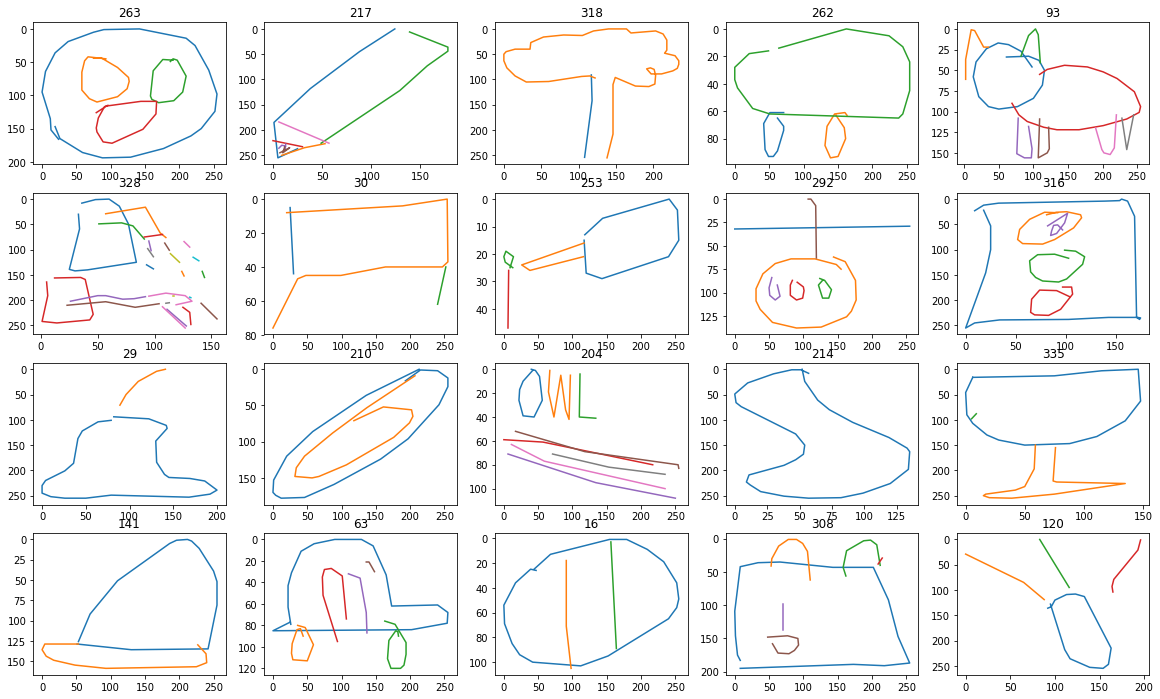

In [14]:
# feature exploration: image
drawplot(df_data.loc[:19, 'drawing'], df_data.loc[:19, 'word'], nrows=4)

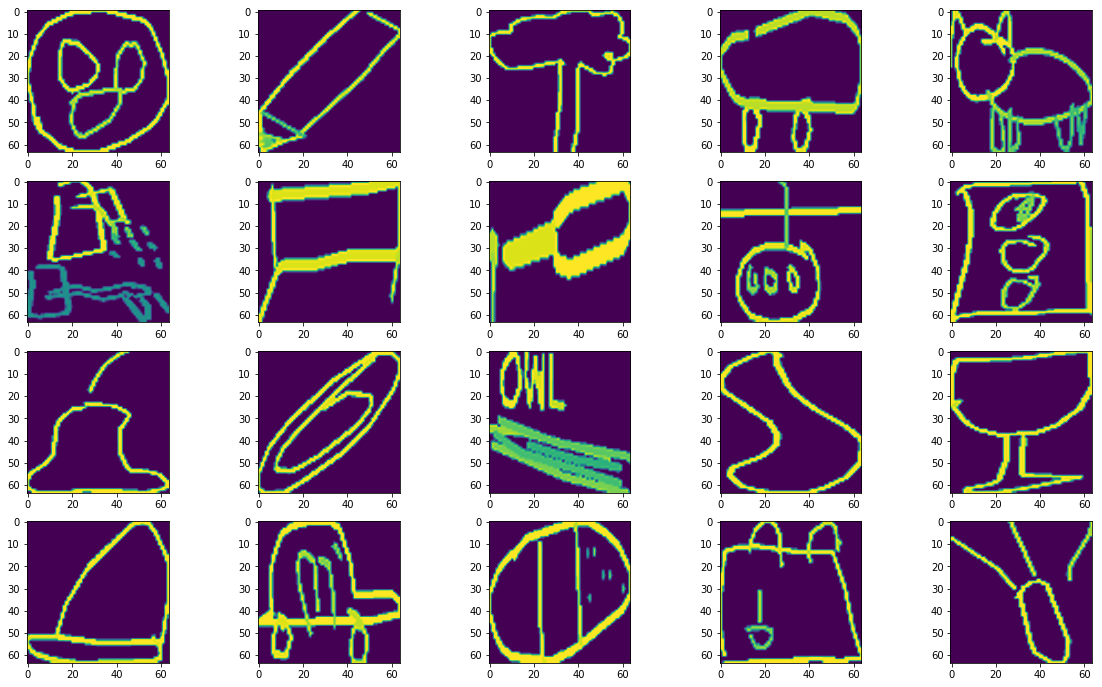

In [15]:
# feature exploration: image
imageplot(df_data.loc[:19, 'pixel'], df_data.loc[:19, 'word'], nrows=4)

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [16]:
# feature exploration, engineering and cleansing
def feature_extraction2(df_data):
    # feature extraction: remove countrycode, drawing and datatype
    df_data = df_data.drop(['countrycode', 'drawing', 'datatype'], axis=1)
    
    return df_data

In [17]:
# feature extraction: step 2
df_data = feature_extraction2(df_data)

In [18]:
# describe data dataframe
df_data.describe(include='all')

,key_id,word,recognized,pixel
count,1.020000e+02,102.000000,102,102
unique,NaN,NaN,2,102
top,NaN,NaN,True,"[[0.11840245863970587, 0.592156862745098, 0.59..."
freq,NaN,NaN,89,1
mean,5.689944e+15,183.107843,NaN,NaN
std,8.109642e+14,107.148265,NaN,NaN
min,4.514931e+15,-1.000000,NaN,NaN
25%,5.073926e+15,92.250000,NaN,NaN
50%,5.608470e+15,189.500000,NaN,NaN
75%,6.238597e+15,278.750000,NaN,NaN


In [19]:
# verify dtypes object
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 4 columns):
key_id        102 non-null int64
word          102 non-null int64
recognized    102 non-null bool
pixel         102 non-null object
dtypes: bool(1), int64(2), object(1)
memory usage: 2.6+ KB


In [20]:
# memory clean-up
del df_data, df_train, df_test
gc.collect()

40187

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [21]:
# training data generator function
def train_generator():
    while True:
        for k in np.random.permutation(range(num_shuffles - 1)):
            for df_data in pd.read_csv('../input/quick-draw-doodle-recognition-challenge-shufflecsv/train_k%d.csv.gz' %k, chunksize=chunksize):
                # feature extraction: drawing
                df_data['drawing'] = df_data['drawing'].apply(lambda x: json.loads(x))
                
                # feature extraction: word
                df_data['word'] = df_data['word'].apply(lambda x: -1 if x == '' else class_dict[x.replace(' ', '_')])
                
                # feature extraction: drawing to pixel
                x = np.zeros((df_data.shape[0], img_size, img_size, 1))
                for i, drawing in enumerate(df_data['drawing'].values): x[i, :, :, 0] = drawing2pixel(drawing)
                y = keras.utils.to_categorical(df_data['word'], num_classes=num_classes)
                yield x, y

# training data generator
gen_train = train_generator()

In [22]:
# testing (validating) data
df_data = pd.read_csv('../input/quick-draw-doodle-recognition-challenge-shufflecsv/train_k%d.csv.gz' %(num_shuffles - 1), nrows=34000)

# feature extraction: drawing
df_data['drawing'] = df_data['drawing'].apply(lambda x: json.loads(x))

# feature extraction: word
df_data['word'] = df_data['word'].apply(lambda x: -1 if x == '' else class_dict[x.replace(' ', '_')])

# feature extraction: drawing to pixel
x_validate = np.zeros((df_data.shape[0], img_size, img_size, 1))
for i, drawing in enumerate(df_data['drawing'].values): x_validate[i, :, :, 0] = drawing2pixel(drawing)
y_validate = keras.utils.to_categorical(df_data['word'], num_classes=num_classes)

In [23]:
# memory clean-up
del df_data
gc.collect()

7

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional network.
* A loss measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

In [24]:
# top_3_categorical_accuracy function
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [25]:
# mobilenet model setup
model_mobilenet = MobileNet(input_shape=(img_size, img_size, 1), alpha=1.0, dropout=1e-3, weights=None, classes=num_classes)
model_mobilenet.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseC

In [26]:
# mobilenet model setup
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[top_3_categorical_accuracy])

# mobilenet model fit
hist = model_mobilenet.fit_generator(gen_train, steps_per_epoch=800, epochs=96, verbose=2, validation_data=(x_validate, y_validate))
model_hist = pd.DataFrame(hist.history)

# mobilenet model metrics
model_mobilenet_score = model_mobilenet.evaluate(x_validate, y_validate, verbose=1)
print('mobilenet\n  top 3 categorical accuracy score: %0.4f' %model_mobilenet_score[1])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/96
34000/34000 [==============================] - 4s 128us/sample - loss: 2.4570 - top_3_categorical_accuracy: 0.6461
 - 230s - loss: 3.0828 - top_3_categorical_accuracy: 0.5084 - val_loss: 2.4570 - val_top_3_categorical_accuracy: 0.6461
Epoch 2/96
34000/34000 [==============================] - 3s 102us/sample - loss: 1.9866 - top_3_categorical_accuracy: 0.7375
 - 220s - loss: 1.7442 - top_3_categorical_accuracy: 0.7714 - val_loss: 1.9866 - val_top_3_categorical_accuracy: 0.7375
Epoch 3/96
34000/34000 [==============================] - 4s 110us/sample - loss: 1.7590 - top_3_categorical_accuracy: 0.7786
 - 220s - loss: 1.5364 - top_3_categorical_accuracy: 0.8076 - val_loss: 1.7590 - val_top_3_categorical_accuracy: 0.7786
Epoch 4/96
34000/34000 [==============================] - 3s 101us/sample - loss: 1.6181 - top_3_categorical_accuracy: 0.7974
 - 220s - 

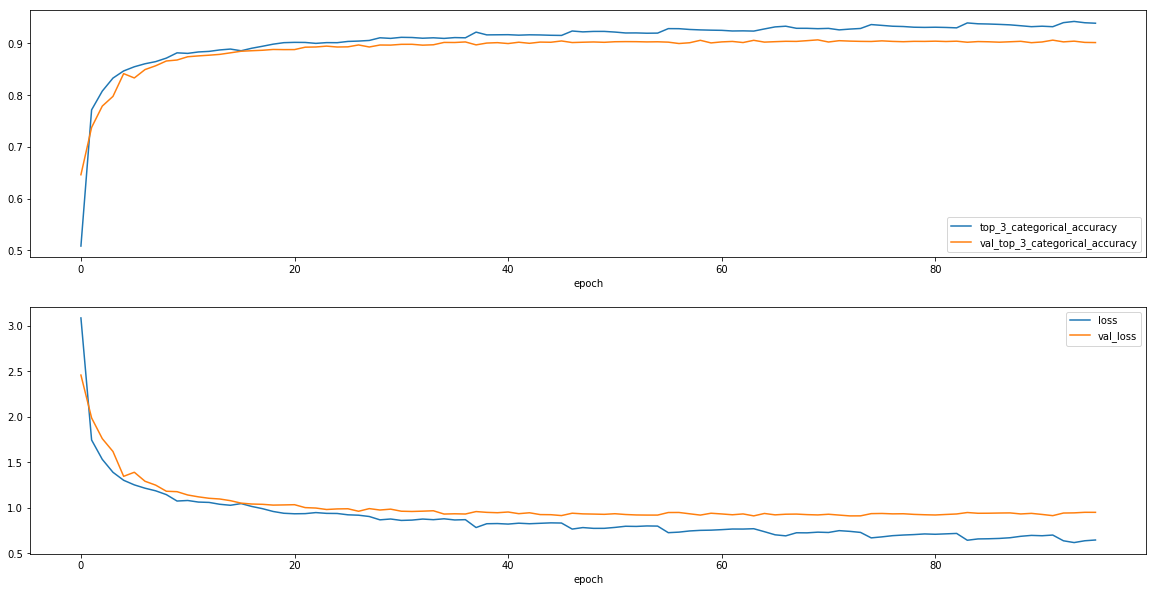

In [27]:
# plot the model history
fig, axes = plt.subplots(figsize=(20, 10), ncols=1, nrows=2)
axes = axes.flatten()
model_hist.plot(y='top_3_categorical_accuracy', kind='line', ax=axes[0])
model_hist.plot(y='val_top_3_categorical_accuracy', kind='line', ax=axes[0])
model_hist.plot(y='loss', kind='line', ax=axes[1])
model_hist.plot(y='val_loss', kind='line', ax=axes[1])
for axis in axes: axis.set_xlabel('epoch')

In [28]:
# mobilenet model save
model_mobilenet.save('model_mobilenet.h5')

In [29]:
# memory clean-up
del x_validate, y_validate
gc.collect()

70

> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [30]:
# acquiring testing data
df_test = pd.read_csv('../input/quickdraw-doodle-recognition/test_simplified.csv')

# feature extraction: drawing
df_test['drawing'] = df_test['drawing'].apply(lambda x: json.loads(x))

In [31]:
# prepare testing data and compute the observed value
x_test = np.zeros((df_test.shape[0], img_size, img_size, 1))
for i, drawing in enumerate(df_test['drawing'].values): x_test[i, :, :, 0] = drawing2pixel(drawing)
y_test = np.argsort(-model_mobilenet.predict(x_test, verbose=1))[:, 0:3]
df_word = pd.DataFrame({'top 1': y_test[:, 0], 'top 2': y_test[:, 1], 'top 3': y_test[:, 2]})
df_word = df_word.replace(classreverse_dict)
df_word['submission'] = df_word['top 1'] + ' ' + df_word['top 2'] + ' ' + df_word['top 3']

112199/112199 [==============================] - 17s 148us/sample


In [32]:
# submit the results
out = pd.DataFrame({'key_id': df_test['key_id'], 'word': df_word['submission']})
out.to_csv('submission.csv', index=False)

In [33]:
# visualize head of the submitted results
out.head(n=5)

,key_id,word
0,9000003627287624,radio stereo snorkel
1,9000010688666847,hockey_puck bottlecap pool
2,9000023642890129,The_Great_Wall_of_China castle fence
3,9000038588854897,mountain boomerang rainbow
4,9000052667981386,campfire fireplace fire_hydrant
